<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/add_2024_content/3_Mi_primera_red_neuronal_Creando_y_entrenando_modelos_con_pytorch_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creando y entrenando modelos con Pytorch

En esta notebook  veremos:
- Modelo de Pytorch Simple
  - Creación
  - Entrenamiento
  - Evaluación
  - Guardar y recuperar modelos.
  - Diferentes tipos de optimizadores.

In [1]:
# %%capture sirve para no mostrar todas las instalaciones que está haciendo.
# Si bien es un comando que está bueno, hay que tener cuidado ya que si alguna instalación no funciona, no nos enteramos.
# Consejo: Ejecutar una vez las instalaciones SIN el capture, luego cuando estemos
# seguros que todo funciona, le agregamos el capture para dejar más limpia la notebook.
%%capture
!pip install torch
!pip install torchvision
!pip install torchsummary

In [2]:
import numpy as np
import pandas as pd
import torch
import tqdm

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [3]:
seed = 14

## Información útil sobre los imports

1. [**torch.nn:**](https://pytorch.org/docs/stable/nn.html) Es un módulo en PyTorch que proporciona un conjunto de clases y funciones para definir, construir y entrenar redes neuronales. Facilita la creación y configuración de modelos de aprendizaje profundo.

2. [**torch.nn.functional:**](https://pytorch.org/docs/stable/nn.functional.html#) es un módulo en PyTorch que proporciona funciones de operaciones y transformaciones específicas de redes neuronales que se utilizan comúnmente en el desarrollo de modelos de aprendizaje profundo. Se enfoca en operaciones y funciones que no tienen estados ni parámetros entrenables (por ejemplo funciones de activación).


## Modelo de Pytorch Simple

La introducción previa de Programación Orientada a Objetos es muy importante al momento definir un modelo de Pytorch:

1. Todo modelo de Pytorch debe heredar propiedades y comportamientos de la clase **`nn.Module`** de pytorch. Por lo tanto, cada modelo que definamos es una clase en sí con atributos y métodos.
2. Dentro de los atributos que definimos se encuentra principalmente el "esqueleto" de nuestra red:
  - Cantidad de entradas,
  - cantidad de capas ocultas,
  - dimensión de la salida, etc.
3. Dentro de los métodos se encuentran principalmente el foward pass y el backpropagation.

Vamos a crear un modelo simple utilizando el conocido dataset de iris de scikit-learn. Este dataset tiene 4 features de entrada:
- `sepal length`,
- `sepal width`,
- `petal length` y
- `petal width`

y es un problema de clasificación con 3 clases:
  - `Setosa` (0),
  - `Versicolor` (1) y
  - `Virginica` (2).


### Descargamos el dataset de iris

In [4]:
iris = datasets.load_iris()

# Veamos que forma tiene:
# np.c_ es una función de numpy que  para concatenar arrays
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
# Separar X e y
X = iris_df.drop('target',axis=1).values
y = iris_df['target'].values

In [6]:
# Dividir el conjunto de datos en conjuntos de entrenamiento, validación y test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)


In [7]:
# Convertir los datos en tensores de PyTorch
X_train = torch.Tensor(X_train)  # con Tensor, especificamos que es float
y_train = torch.LongTensor(y_train)  # con LongTensor, especificamos que es int

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


### Definimos el modelo

In [8]:
class MyFirstPytorchModel(nn.Module):
    def __init__(self,
                 input_features = 4, # Cantidad de features de entrada
                 hidden_layer_1 = 8, # Cantidad de neuronas de la primera capa oculta
                 hidden_layer_2 = 9, # Cantidad de neuronas de la segunda capa oculta
                 output_features = 3 # Dimensión de la salida: ¿Cuántas clases quiero predecir?
                 ):
        super().__init__() # Llama al método __init__ de la clase nn.Module
        # Generamos una red con 3 capas lineales (la última es de salida)
        self.fully_connected_1 = nn.Linear(input_features, hidden_layer_1)
        self.fully_connected_2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.output = nn.Linear(hidden_layer_2, output_features)

    # Foward pass
    def forward(self, x):
      # defino cómo se va a transformar la entrada
      x = F.relu(self.fully_connected_1(x))
      x = F.relu(self.fully_connected_2(x))
      x = self.output(x)
      return x

**Nota:**

- **`super().__init__`** llama al método `__init__()` de la clase padre (en este caso `nn.Module`), permitiendo que la inicialización de la clase padre se ejecute antes de que la subclase (en este caso `MyFirstPytorchModel`) realice su propia inicialización.

**Documentación útil:**
- [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

In [9]:
# Para hacer que el entrenamiento sea reproducible
torch.manual_seed(seed)

model     = MyFirstPytorchModel() #Instanciamos la clase
# En el caso de nn.CrossEntropyLoss() la función softmax ya está implicitamente incluida por pytorch
criterion = nn.CrossEntropyLoss() # Función de loss para problemas multiclase
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Definimos el optimizador
model.parameters

<bound method Module.parameters of MyFirstPytorchModel(
  (fully_connected_1): Linear(in_features=4, out_features=8, bias=True)
  (fully_connected_2): Linear(in_features=8, out_features=9, bias=True)
  (output): Linear(in_features=9, out_features=3, bias=True)
)>

**Documentación útil:**

- [`torch.no_grad`](https://pytorch.org/docs/stable/generated/torch.no_grad.html): Desactiva el cálculo de los gradientes. Puede tener varios usos pero en este caso el principal es, teniendo el modelo ya entrenado, evaluar en un conjunto nuevo para ver la predicción. En este caso, los pesos de la red ya fueron aprendidos.

In [10]:
#epoch = Un entrenamiento sobre todo el dataset
epochs = 100

train_losses = []
val_losses = []

for epoch in tqdm.trange(epochs):
    epoch+=1

    # optimizer.zero_grad() setea todos los gradientes en cero, sino se acumulan
    # y estariamos usando valores de gradiente que ya usamos previamente
    optimizer.zero_grad()
    # Foward pass y obtener la prediccion
    y_pred = model.forward(X_train)

    # Calcular la loss de cada epoca
    loss_train = criterion(y_pred, y_train)

    loss_train.backward()  # backward() calcula los gradientes de las operaciones realizadas
    optimizer.step()  # realiza paso de optimización, actualizando todos los parametros del modelo (pesos y biases)

    train_losses.append(loss_train.item())

    # No queremos imprimir los resultados de las 100 epocas asi que podemos poner una condicion
    if epoch%10 == 1:
       print(f'epoch: {epoch:2}  loss: {loss_train.item():10.8f}')

    with torch.no_grad():  # dentro del with impedimos se procesen gradientes para evaluar
        # Foward pass y obtener la prediccion
        y_pred_val = model.forward(X_val)

        # Calcular la loss de cada epoca
        loss_val = criterion(y_pred_val, y_val)
        val_losses.append(loss_val.item())


 28%|██▊       | 28/100 [00:00<00:00, 143.54it/s]

epoch:  1  loss: 1.09474826
epoch: 11  loss: 0.28536552
epoch: 21  loss: 0.12064412
epoch: 31  loss: 0.08891094

 45%|████▌     | 45/100 [00:00<00:00, 150.13it/s]


epoch: 41  loss: 0.08548603
epoch: 51  loss: 0.07803762


 90%|█████████ | 90/100 [00:00<00:00, 143.23it/s]

epoch: 61  loss: 0.07238930
epoch: 71  loss: 0.06782731
epoch: 81  loss: 0.06596272
epoch: 91  loss: 0.06442944


100%|██████████| 100/100 [00:00<00:00, 143.01it/s]


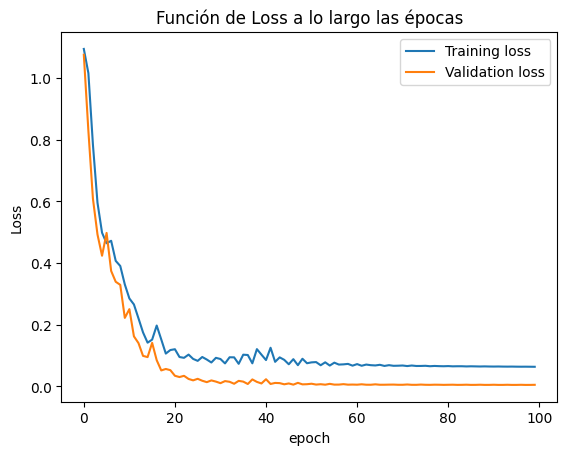

In [11]:
plt.title('Función de Loss a lo largo las épocas')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Evaluamos el modelo

In [12]:
# Evaluamos el modelo en el conjunto de validación
with torch.no_grad():
    y_pred = model.forward(X_val)  # Hacemos una inferencia sobre el conjunto de datos
    loss = criterion(y_pred, y_val)
print(f'Valor de Loss en el conjunto de validación: {loss:.8f}')

Valor de Loss en el conjunto de validación: 0.00520135


**Ejercicio:** En este caso solo hicimos una prueba con 100 épocas, ¿que pasaría si agregamos/sacamos épocas? El ejercicio consiste en probar diferentes configuraciones de épocas y quedarse con la que consideren más adecuada. Una vez que se hayan decidido probar el resultado final en el conjunto de test que definimos arriba (recuerden que el conjunto de test se utiliza una sola vez).

In [13]:
## Este es un ejemplo visual donde comparamos ejemplo, el valor predicho con la pertenencia a la clase.

correct = 0
with torch.no_grad():
    for i,data in enumerate(X_val):
        y_pred = model.forward(data)

        # Mientras más alto es el valor más alta es la probabilidad de que pertenezca a la clase
        print(f'Ejemplo {i+1:2}.) {str(y_pred):38}  {y_val[i]}')

        if y_pred.argmax().item() == y_val[i]:
            correct += 1
print(f'\n{correct} out of {len(y_val)} = {100*correct/len(y_val):.2f}% correct')

Ejemplo  1.) tensor([-9.1017,  4.2634, -4.6722])     1
Ejemplo  2.) tensor([ 18.3230,   1.1823, -22.5088])  0
Ejemplo  3.) tensor([ 20.0544,   0.6699, -23.4931])  0
Ejemplo  4.) tensor([ 15.4738,   1.5249, -19.8096])  0
Ejemplo  5.) tensor([-9.3940,  3.9568, -4.1068])     1
Ejemplo  6.) tensor([-5.6320,  4.4984, -5.8759])     1
Ejemplo  7.) tensor([-22.5894,   0.7971,   5.4438])  2
Ejemplo  8.) tensor([-24.2313,  -0.3200,   8.1761])  2
Ejemplo  9.) tensor([ 2.4541e+01, -3.5940e-03, -2.7532e+01])  0
Ejemplo 10.) tensor([-10.3721,   3.6153,  -3.0839])  1
Ejemplo 11.) tensor([-12.1129,   3.4009,  -2.1979])  1
Ejemplo 12.) tensor([-26.0888,  -0.0517,   8.1493])  2
Ejemplo 13.) tensor([ 18.2501,   0.8233, -21.6893])  0
Ejemplo 14.) tensor([ 16.2425,   1.2798, -20.2366])  0
Ejemplo 15.) tensor([-18.6494,   0.5985,   4.9422])  2
Ejemplo 16.) tensor([-12.1940,   2.7023,  -0.9272])  1
Ejemplo 17.) tensor([-19.5524,   1.2385,   4.0647])  2
Ejemplo 18.) tensor([-7.9062,  3.9300, -4.3600])     1
E

### Guardamos el modelo

In [14]:
# model.state_dict() guarda los pesos y los parametros del modelo
# La extension .pt es una convencion, también se suele usar .pth (son abreviaturas de pytorch)
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

In [15]:
new_model = MyFirstPytorchModel()
# load_state_dict se utiliza para cargar los parametros entrenados del modelo
# Es muy importante que el momento que se quiere cargar coincida con la arquitectura del modelo definido
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))
# Poner un modelo en "modo evaluacion" implica desactivar cualquier tipo de
# optimización relacionada con el entrenamiento (dropout, normalizacion por lotes, actualizacion de pesos, etx)
new_model.eval()

<ipython-input-15-bf4eb98d6421>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))


MyFirstPytorchModel(
  (fully_connected_1): Linear(in_features=4, out_features=8, bias=True)
  (fully_connected_2): Linear(in_features=8, out_features=9, bias=True)
  (output): Linear(in_features=9, out_features=3, bias=True)
)

### Evaluemos el modelo en un ejemplo concreto

In [16]:
# Definimos un tensor "aleatorio"
mystery_iris = torch.tensor([5.6,0,2.2,0.5])

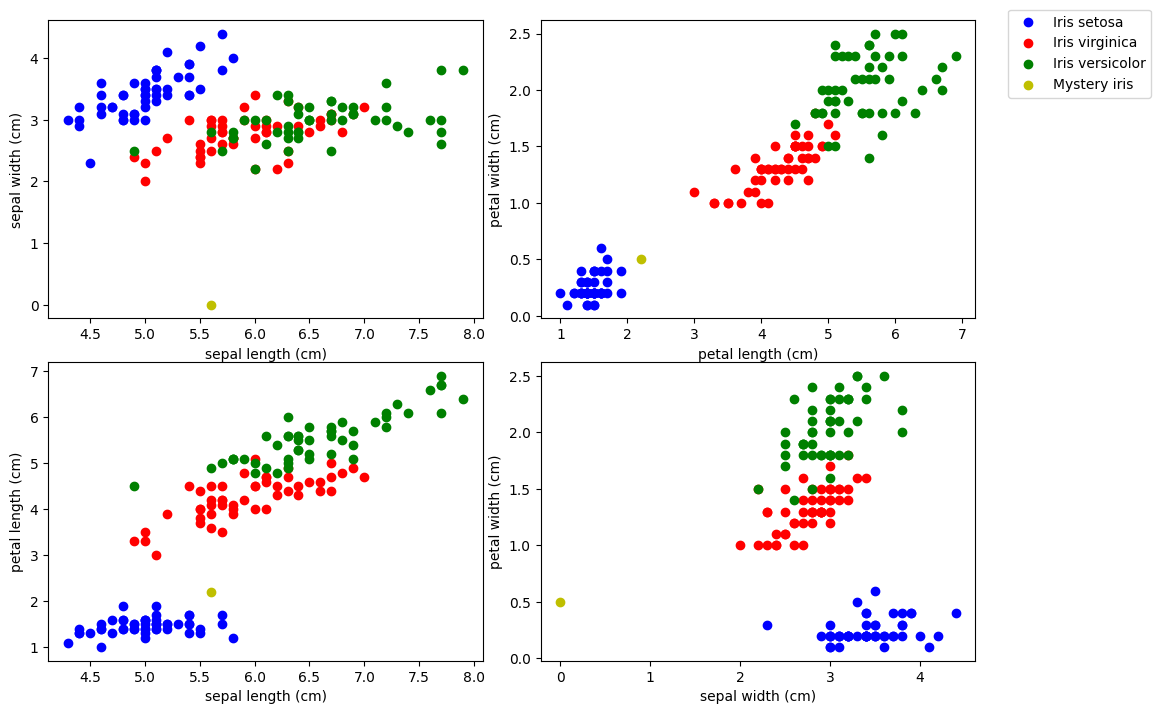

In [17]:
# Dado el tensor que definimos veamos "donde queria situado" graficamente
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = iris_df.columns[plots[i][0]]
        y = iris_df.columns[plots[i][1]]
        ax.scatter(iris_df[iris_df['target']==j][x], iris_df[iris_df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [18]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print()
    print(labels[new_model(mystery_iris).argmax()])

tensor([-3.8862,  4.6323, -6.9775])

Iris virginica


**Ejercicio:** Prueben diferentes valores en el tensor y jueguen!